<a href="https://colab.research.google.com/github/HssahSaad/Week_6/blob/main/YOLO_Practical_Exam_Hssah_Alsherihi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Traffic Vehicle Counting Exam

In this exam, you will use the YOLO (You Only Look Once) object detection model to analyze a video of road traffic. Your primary task is to count the number of vehicles exiting the road at each of the four exits (located at the top, bottom, left, and right of the frame). The video for this task is provided at `Datasets/YOLO_Exam_Video.mp4`.

## Objectives
- Load and process the video using OpenCV.
- Utilize the YOLO model to detect vehicles in each frame.
- Manipulate the video frames using OpenCV.
- Track vehicles as they move across the video frames.
- Count the number of vehicles exiting via the top street.
- Count the number of vehicles exiting via the bottom street.
- Count the number of vehicles exiting via the left street.
- Count the number of vehicles exiting via the right street.


## Setup Environment

Before you begin, ensure you have the necessary libraries installed. You will need `opencv`, and `ultralytics` among others.
If these are not installed, you should install them.

In [1]:
%pip install ultralytics

In [2]:
from ultralytics import YOLO
import numpy as np
import cv2

## Load the YOLO Model

You will first need to load the YOLO model, there is a custom model for this exam called `YOLO_Model.pt` under Datasets file ⚠️ PLEASE USE THIS MODEL AND DO NOT USE ANY OTHER MODEL ⚠️.
Write the code to load the YOLO model below:

In [3]:
model = YOLO('/content/YOLO_Model (2).pt')

## Prepare the Video Capture

Create a variable to capture the video frames, you can use `cv2.VideoCapture()` to achive this.

In [4]:
video_path = '/content/YOLO_Video.mp4'
cap = cv2.VideoCapture(video_path)

## Get Video Information

You can use `cv2` library to get these information fro the `VideoCapture()` variable you created to extract these information:
* `height`: Video's height.
* `width`: Video's width.
* `fps`: Video's frames.

In [5]:
width = int(cap.get(3))
height = int(cap.get(4))
fps = int(cap.get(5))

In [6]:
width

1920

In [7]:
height

1080

In [8]:
fps

29

## Prepare Video Writer to Store the Output

Create a variable that uses `cv2.VideoCapture()` to save the video with the bounding boxes, specified Region of Interest rectangle (ROI) and the counted vehicles on each sides. You will need to make the video with the same `fps`, `width`, `height`, and specify the codec and output path of the video.

In [9]:
output_video = '/content/output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

## Expermint to get the `(x1, y1, x2, y2)` of the ROI

### Hint
When defining the Regions of Interest (ROIs) for detecting vehicles exiting the road, consider the coordinates that outline the relevant areas. These coordinates can be specified as `(x1, y1, x2, y2)`, where `(x1, y1)` is the top-left corner and `(x2, y2)` is the bottom-right corner of the rectangle.

Experiment with different coordinates to accurately cover the streets where vehicles exit. Visualize these ROIs by drawing rectangles on a frame of the video and adjust the coordinates as needed until you capture the desired areas effectively.

In [10]:
# ROI Coordinates
roi_top = (600, 100, 1200, 400)         # Top exit
roi_bottom = (700, 800, 1200, 1000)     # Bottom exit
roi_left = (100, 400, 500, 800)         # Left exit
roi_right = (1420, 400, 1820, 800)      # Right exit


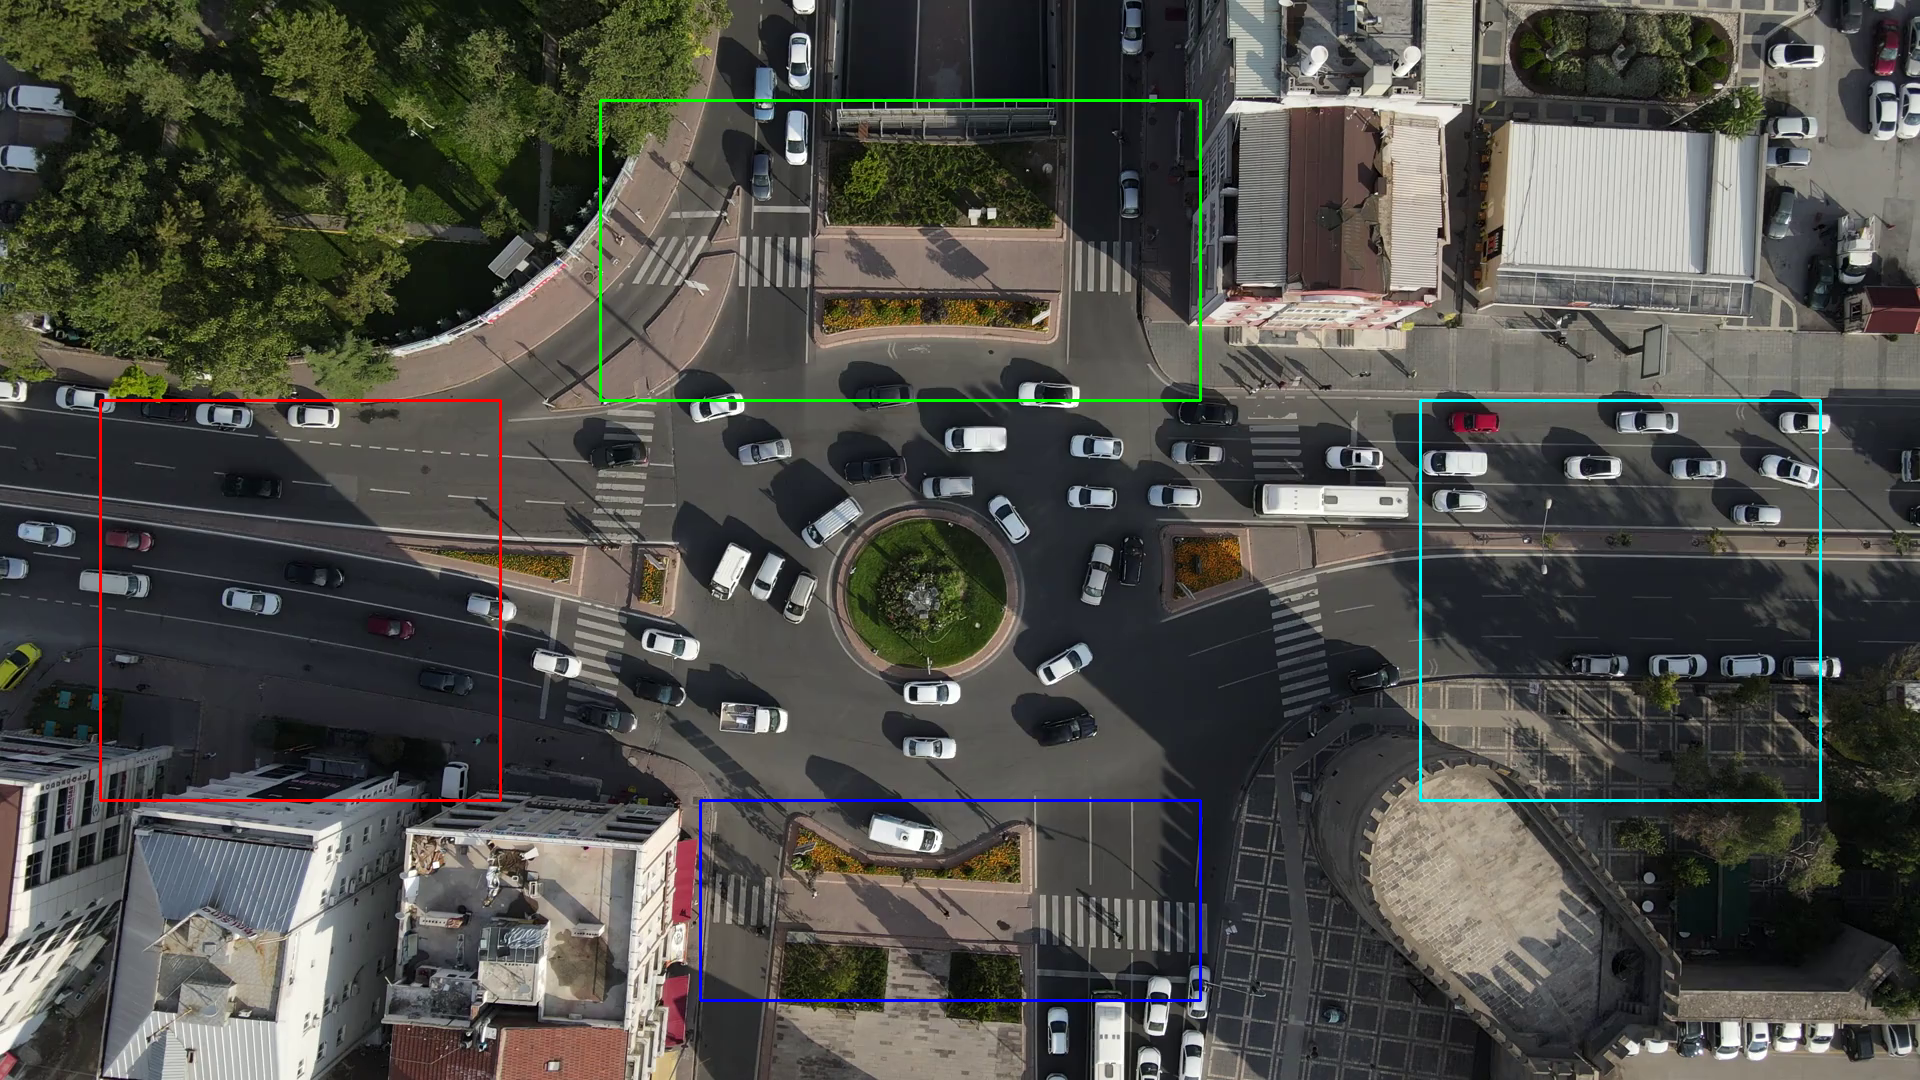

In [11]:
from google.colab.patches import cv2_imshow

ret, frame = cap.read()
if ret:
    cv2.rectangle(frame, (roi_top[0], roi_top[1]), (roi_top[2], roi_top[3]), (0, 255, 0), 2)
    cv2.rectangle(frame, (roi_bottom[0], roi_bottom[1]), (roi_bottom[2], roi_bottom[3]), (255, 0, 0), 2)
    cv2.rectangle(frame, (roi_left[0], roi_left[1]), (roi_left[2], roi_left[3]), (0, 0, 255), 2)
    cv2.rectangle(frame, (roi_right[0], roi_right[1]), (roi_right[2], roi_right[3]), (255, 255, 0), 2)

    cv2_imshow(frame)


## Process Video Frames and Identify Vehicles Left the Road Form Each Street

For each frame in the video, use the YOLO model to detect and track vehicles. You will need to write a loop that processes each frame and applies the YOLO model.

In each frame, after detecting the vehicles, determine whether they exited the road via the top, bottom, left, or right street. You can use the positions of the bounding boxes provided by YOLO to do this.

- The video should display bounding boxes around the detected objects.
- The video should display your name on the top.
- It should display the calculated center of each vehicle.
- The video should display the confidence score, alongside the object ID and class ID of each detected and tracked object.
- The video should display the rectangles representing the regions where you count the vehicles that have crossed and exited.
- The video should display the number of vehicles that exited via the top street.
- The video should display the number of vehicles that exited via the bottom street.
- The video should display the number of vehicles that exited via the left street.
- The video should display the number of vehicles that exited via the right street.

In [12]:
color = (0, 255, 0)
thickness = 2
font = cv2.FONT_HERSHEY_SIMPLEX

In [13]:
# Define region points
region_points = [
    (600, 100, 1200, 400),  # Top region
    (700, 800, 1200, 1000),  # Bottom region
    (100, 400, 500, 800),  # Left region
    (1420, 400, 1820, 800)  # Right region
]

In [14]:
# Initialize counters for vehicles exiting
top_exit_count = 0
bottom_exit_count = 0
left_exit_count = 0
right_exit_count = 0

# Dictionary to store the last known position of each tracked object
last_positions = {}

ret = True
while ret:
    ret, frame = cap.read()

    if not ret:
        break

    results = model.track(frame, persist=True)

    for result in results:
        for obj in result.boxes:
            bbox = obj.xyxy[0].cpu().numpy()  # Bounding box coordinates
            class_id = int(obj.cls[0].cpu().numpy()) if obj.cls is not None else -1  # Class ID
            conf = obj.conf[0].cpu().numpy() if obj.conf is not None else 0.0  # Confidence score
            obj_id = int(obj.id[0].cpu().numpy())  # Unique ID for the tracked object

            x1, y1, x2, y2 = map(int, bbox)

            # Calculate the center of the bounding box
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2

            if obj_id not in last_positions:
                last_positions[obj_id] = (center_x, center_y)

            # Check if  the center of the bounding box inside the region
            if region_points[0][0] <= center_x <= region_points[0][2] and region_points[0][1] <= center_y <= region_points[0][3]:
                # Check if the object was previously outside this region to avoid multiple counts
                if last_positions[obj_id][1] < region_points[0][1]:
                    top_exit_count += 1
            elif region_points[1][0] <= center_x <= region_points[1][2] and region_points[1][1] <= center_y <= region_points[1][3]:
                if last_positions[obj_id][1] > region_points[1][3]:
                    bottom_exit_count += 1
            elif region_points[2][0] <= center_x <= region_points[2][2] and region_points[2][1] <= center_y <= region_points[2][3]:
                if last_positions[obj_id][0] < region_points[2][0]:
                    left_exit_count += 1
            elif region_points[3][0] <= center_x <= region_points[3][2] and region_points[3][1] <= center_y <= region_points[3][3]:
                if last_positions[obj_id][0] > region_points[3][2]:
                    right_exit_count += 1

            # Update the last known position of the object
            last_positions[obj_id] = (center_x, center_y)

            # Draw the bounding box for each detection
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)

            # Prepare the label
            label = f'ID: {obj_id} Class: {class_id} Conf: {conf:.2f}'

            # Put the label on the frame
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2, cv2.LINE_AA)

    # Display the counters on the frame
    cv2.putText(frame, f"Top exit count: {top_exit_count}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f"Bottom exit count: {bottom_exit_count}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f"Left exit count: {left_exit_count}", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, f"Right exit count: {right_exit_count}", (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)

    # Write the processed frame to the video file
    video_writer.write(frame)

# Release video capture and writer
cap.release()
video_writer.release()



WARNING ⚠️ NMS time limit 2.050s exceeded
0: 384x640 2 buss, 82 cars, 2 trucks, 2 vans, 219.3ms
Speed: 4.1ms preprocess, 219.3ms inference, 2484.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 buss, 82 cars, 2 trucks, 2 vans, 76.4ms
Speed: 17.8ms preprocess, 76.4ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 buss, 82 cars, 2 trucks, 2 vans, 74.8ms
Speed: 5.8ms preprocess, 74.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 buss, 82 cars, 2 trucks, 2 vans, 66.3ms
Speed: 4.0ms preprocess, 66.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 buss, 82 cars, 2 trucks, 2 vans, 63.0ms
Speed: 4.2ms preprocess, 63.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 buss, 82 cars, 2 trucks, 2 vans, 67.2ms
Speed: 3.5ms preprocess, 67.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 buss, 84 cars, 2 trucks, 2 vans,

## Save and Submit Your Work

Submit both the notebook and the output video

In [18]:
!zip -r /content/runs/detect/train.zip /content/runs/detect/train

	zip warning: name not matched: /content/runs/detect/train

zip error: Nothing to do! (try: zip -r /content/runs/detect/train.zip . -i /content/runs/detect/train)
